In [1]:
import glob, os, sys
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

def build_model_config(work_dir_root, train_date, configration, device='cuda:0'):
    config_file = os.path.join(work_dir_root, f'{train_date}_{configration}', configration + '.py')
    checkpoint_file = os.path.join(work_dir_root, f'{train_date}_{configration}', 'latest.pth')
    model = init_segmentor(config_file, checkpoint_file, device=device)
    return model

def collect_images(*paths):
    def collect(path):
        images = []

        # glob multiple filetypes
        for ext in ['*.jpg', '*.png', '*.jpeg']:
            images.extend(glob.glob(os.path.join(path, ext)))

        images.sort()
        return images

    return [collect(path) for path in paths]

/home/ranhui/Software/miniconda3/envs/mmseg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# work_dir_root = '../work_dirs/seg_compare'
# train_date = '20221025-101345'
# configration = 'upernet_r101-d8_480x480_320k_irfissure-fusion-mixup'

work_dir_root = '../work_dirs'
train_date = '20230625-103848'
configration = 'deeplabv3_r50-d8_480x480_48k_irfissure-fusion-mixup'

source_foldes = ['../data/custom_dataset/IR_fissure/fusion/images/improved_ddcgan']

In [3]:
# build the model from a config file and a checkpoint file
model = build_model_config(work_dir_root, train_date, configration, 'cpu')

/home/ranhui/Workspace/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../work_dirs/20230625-103848_deeplabv3_r50-d8_480x480_48k_irfissure-fusion-mixup/latest.pth


In [4]:
result_dir = os.path.join(work_dir_root, f'{train_date}_{configration}', 'results')
os.makedirs(result_dir, exist_ok=True)

imgs = collect_images(*source_foldes)

for i, source_folder in enumerate(source_foldes):
    for j, img_path in enumerate(imgs[i]):
        # show progress bar roughly
        sys.stdout.write('\r[{}/{}] [{}/{}] {}'.format(i + 1, len(source_foldes), j + 1, len(imgs[i]), img_path))
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        result = inference_segmentor(model, img_path)
        model.show_result(img_path, result, palette=None, out_file=os.path.join(result_dir, img_name + ".jpg"), opacity=0.8)

In [6]:
# test a single image
img = '../data/custom_dataset/IR_fissure/fusion/images/improved_ddcgan/20201023_130426_458_R.png'
result = inference_segmentor(model, img)

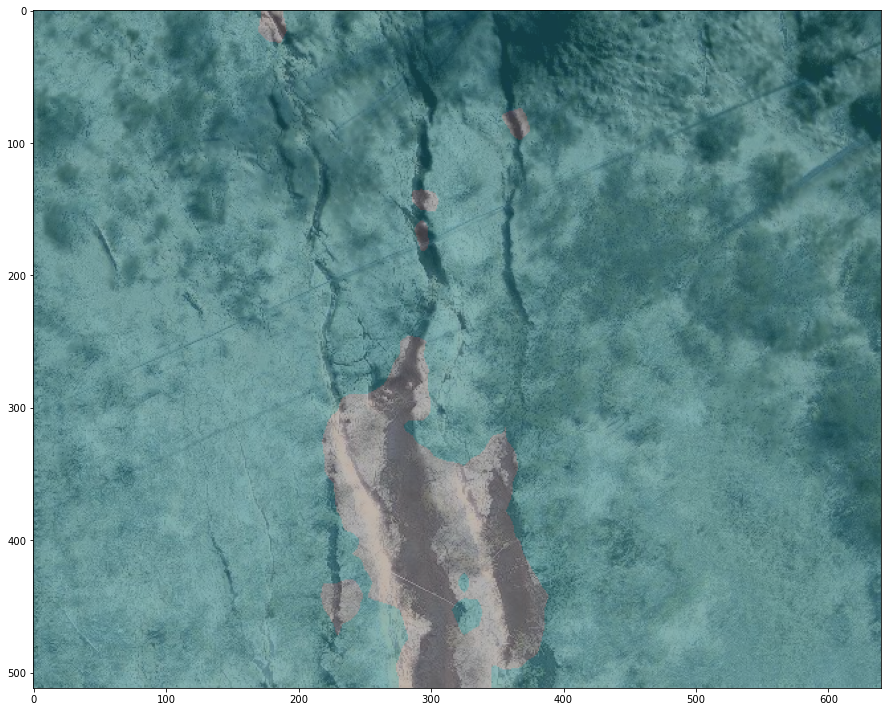

In [7]:
# show the results
show_result_pyplot(model, img, result)

In [8]:
import numpy as np
from PIL import Image
import cv2
from torchvision.transforms import Compose, Normalize, ToTensor

source_foldes = [
    '../data/custom_dataset/IR_fissure/thermal/images/', 
    '../data/custom_dataset/IR_fissure/thumbnail/images/', 
    '../data/custom_dataset/IR_fissure/fusion/images/improved_ddcgan/', 
    # 'irfissure-dataset/origin/DDcGAN/', 
    # 'irfissure-dataset/origin/GTF/', 
    # 'irfissure-dataset/origin/Hybrid_MSD/', 
    # 'irfissure-dataset/origin/MST_SR/', 
    # 'irfissure-dataset/origin/RP_SR/', 
    # 'irfissure-dataset/origin/TIF/', 
    # 'irfissure-dataset/origin/VSMWLS/'
    ]

imgs = collect_images(*source_foldes)

img = np.array(Image.open(imgs[0][0]))
if len(img.shape) == 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
# img = cv2.resize(img, (480, 480))
img = np.float32(img) / 255
preprocessing = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])
input_tensor = preprocessing(img.copy()).unsqueeze(0).to('cpu')

model = model.eval()

model(input_tensor)

TypeError: BaseSegmentor.forward() missing 1 required positional argument: 'img_metas'